# 1. Prepare our 'toy data'

**toy data** : is a small enough data set to experiment with but also sizeable enough to practice the fundamentals.

In [ ]:
# import the libraries
import sklearn
from sklearn.datasets import make_circles
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# load our data form make_circles
n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

# saving our data in pandas data frame
circles = pd.DataFrame({'X1': X[:,0],
                        'X2': X[:,1],
                        'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


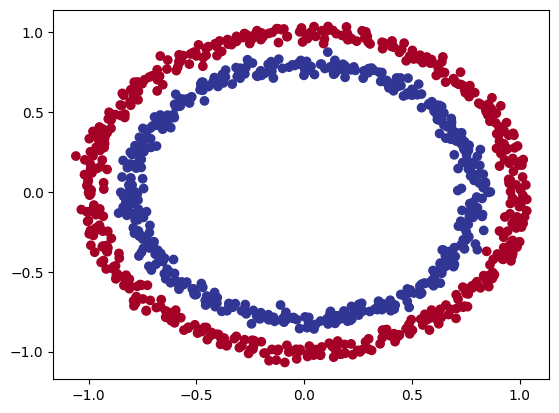

In [ ]:
# visualize our data
plt.scatter(x=circles['X1'],
            y=circles['X2'],
            c=circles['label'],
            cmap=plt.cm.RdYlBu);


## 1.1 ckeck input and output shapes

In [ ]:
X.shape, y.shape # we have 1000 samples, 2 featrures in , 1 feature out

((1000, 2), (1000,))

## 1.2 Turn the data into Tensors and create train test split

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X.dtype , y.dtype , X.shape, y.shape

(torch.float32, torch.float32, torch.Size([1000, 2]), torch.Size([1000]))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,
                                                      test_size = 0.2, # 20%
                                                      random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# 2. Building a model

We will build a model to classify the red and blue dots.

To do so, we need to:
1. Setup device agnoisitc code so we run on an accelerator(GPU).
2. Construct a model (by Subclassing the `nn.Module`).
3. Define a loss function and optimzer.
4. Create a training and testing loop.

In [ ]:
# Import PyTroch and nn
import torch
from torch import nn

# Make device agnositc code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 2.2 Construct a class model

1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` layers for handling the shapse of our data
3. Defines a `forward()` method that outlines the forward pass
4. Instantiate an instance of our model class and send it to the target `device`

In [ ]:
# 1. Construct a model class that subclass nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. create 2 nn.Linear layers to handle our data shapes
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # 2 input from our X data, upscales to 5 features 'hidden layers'
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # 5 input from previos layer, 1 output 'y' our label
    # so we have one hidden layer with 5 nurons

  # 3. Defines a forward() method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

#. Instantiates an instance of our model class and send it to the target devid
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device

device(type='cpu')

### 2.2.1

we can create the same model using nn.Sequential() class but it has less flexibilaty

In [ ]:

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0123, -0.0864],
                      [-0.0009, -0.4491],
                      [-0.0910,  0.2582],
                      [ 0.1436, -0.1213],
                      [-0.6301, -0.1737]])),
             ('0.bias', tensor([ 0.2777,  0.7068, -0.3394, -0.1924,  0.1593])),
             ('1.weight',
              tensor([[-0.0836, -0.2760,  0.3492,  0.3865,  0.2675]])),
             ('1.bias', tensor([-0.1637]))])

In [ ]:
# Make som predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f'frist 10 predictions: {untrained_preds[:10]}')
print(f'first 10 actual labels: {y_test[:10]}')

frist 10 predictions: tensor([[-0.3902],
        [-0.4116],
        [-0.4702],
        [-0.3670],
        [-0.6860],
        [-0.6974],
        [-0.5865],
        [-0.6540],
        [-0.4610],
        [-0.4154]])
first 10 actual labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## Setup a loss function and an optimizer

for logistic regression 'Classification' problems we can use MEA or MSE as a loss function

We need to use some loss fucntion to map our weights and biases to the write outptu layers which are in this case (0,1) Binary Classification

To do so we will use `torch.nn.BCEWithLogitsLoss` this loss function combines `torch.sigmoid` and `torch.nn.BCE` in one class

In [ ]:
# Setup the loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [ ]:
# Setup an accuracy function to measure how our model is doing
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # cacluate the sum of equal numbers of predections and true labels then return it as numpy array
  acc = (correct/len(y_pred)) * 100 # measure the percentage of the accuracy
  return acc

# 3. Train a model

The main steps to train our model are : \\
1. Forward pass 'make predections by passing the train values'
2. Calculate the loss 'using our loss_fn' which uses BCEWithLogitsLoss function
3. Optimizer zero grad 'set the optimizer step to 0 to stop accumulating'
4. loss backward 'backpropagation'
5. Optimizer step 'take the step to adjust our weights and biases to the right directions and values'.

## 3.1 Going from 'raw logits' -> predection probabilities -> predection labels

our model_0 will produce a raw logits that is not our main goal but its an important step .

to convert these 'raw logits' to predection probabilities we need an 'activation function' like `torch.sigmoid` for (Binary Classification) or `torch.softmax` for (MultiClass Classification) to convert the logits into probabilites

then we can round the output of the activation function to a labels : \\
`y_pred_prob` => 0.5 , `y_pred=1` (class 1) \\
`y_pred_prob` < 0.5 , `y_pred=1` (class 0)

In [ ]:
# 1. make some predection (5 samples) on our model
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device)[:5])

# 2. turn the logits to a probabilites using activation function
y_pred_prob = torch.sigmoid(y_logits)

# 3. round the values of the probabilites to map them with our labels
y_pred = torch.round(y_pred_prob)
y_pred

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

## 3.2 Builiding the training and testitg loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# send all training and testing data to the same device
X_train , y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze() # to remove the extra diminsion
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. calcluate the loss
  # our loss function "BCEWithLogitsLoss" will take the logits as a paramter and the true y labels (y_logits)
  # for the "BCELoss" it will tak the probabilites as a paramter (torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_train, y_pred) # test the accuracy using our function

  # 3. optimzer zero grad
  optimizer.zero_grad()

  # 4. loss backward (backward propagation)
  loss.backward()

  # 5. optimizer step (gradiant descent)
  optimizer.step()

  ### Testing
  if epoch % 100 == 0:
    model_0.eval()
    with torch.inference_mode():
      test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy(y_test, test_pred)
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.72988 | Acc: 50.00% | Test Loss: 0.72962 | Test Acc: 50.00%
Epoch: 100 | Loss: 0.70691 | Acc: 50.00% | Test Loss: 0.70652 | Test Acc: 50.00%
Epoch: 200 | Loss: 0.69893 | Acc: 50.00% | Test Loss: 0.69829 | Test Acc: 50.00%
Epoch: 300 | Loss: 0.69599 | Acc: 41.88% | Test Loss: 0.69519 | Test Acc: 43.00%
Epoch: 400 | Loss: 0.69482 | Acc: 47.12% | Test Loss: 0.69397 | Test Acc: 45.00%
Epoch: 500 | Loss: 0.69429 | Acc: 48.12% | Test Loss: 0.69347 | Test Acc: 47.50%
Epoch: 600 | Loss: 0.69402 | Acc: 49.12% | Test Loss: 0.69327 | Test Acc: 48.00%
Epoch: 700 | Loss: 0.69385 | Acc: 49.75% | Test Loss: 0.69320 | Test Acc: 48.00%
Epoch: 800 | Loss: 0.69372 | Acc: 49.75% | Test Loss: 0.69319 | Test Acc: 48.00%
Epoch: 900 | Loss: 0.69363 | Acc: 49.88% | Test Loss: 0.69321 | Test Acc: 48.50%


## 3.3 What is happinig ?

In [ ]:
# lets write some code to import a function that will help us to visualize what our model is doing
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists')
else:
  print('downloading helper_functions.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f :
    f.write(request.content)
from helper_functions import plot_decision_boundary


downloading helper_functions.py


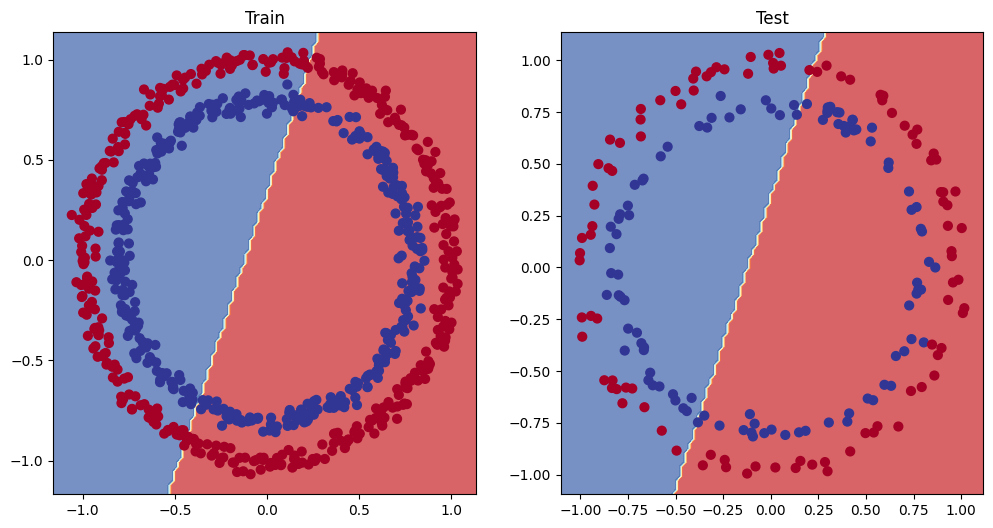

In [ ]:
# plot the boundaries and what our model is doing
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

# 4. We will try to improv the model from the models' presprective

In [ ]:
# define a new class of circle model
# change the number of layers and the number of hidding units
# traing the model for longer time
# change the loss function
# change the activation function
### not all of the apove are nessecry in our case

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [ ]:
# pick a loss funciton
loss_fn = torch.nn.BCEWithLogitsLoss()
# pick an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr = 0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
X_train , y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)
epochs = 1000

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_train, y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 100 == 0:
    model_1.eval()
    with torch.inference_mode():
      test_logits = model_1(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy(y_test, test_pred)
      print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69396 | Acc: 50.88% | Test Loss: 0.69261 | Test Acc: 51.00%
Epoch: 100 | Loss: 0.69305 | Acc: 50.38% | Test Loss: 0.69379 | Test Acc: 48.00%
Epoch: 200 | Loss: 0.69299 | Acc: 51.12% | Test Loss: 0.69437 | Test Acc: 46.00%
Epoch: 300 | Loss: 0.69298 | Acc: 51.62% | Test Loss: 0.69458 | Test Acc: 45.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.12% | Test Loss: 0.69465 | Test Acc: 46.00%
Epoch: 500 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69467 | Test Acc: 46.00%
Epoch: 600 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 700 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 800 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 900 | Loss: 0.69298 | Acc: 51.00% | Test Loss: 0.69468 | Test Acc: 46.00%


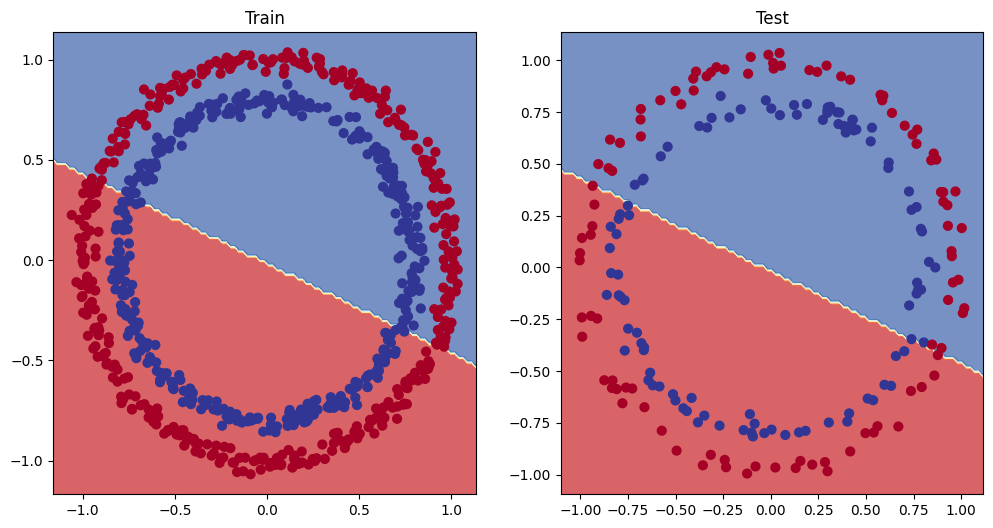

In [ ]:
# the accuracy didn't change that much
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

# 4. Non-Linearity

A non-linear function is a fucntion with straight and not straight lines and that's what we need in our model

## 4.1 Build the non-linear model class using `nn.ReLU`

In [ ]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is non-linear activation function

  def forward(self, x):
    # we will apply the relu function after each layer
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## 4.2 Setup a loss funciton and optimizer

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

## 4.3 Build the training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# send all trainig and testing data to the same device as the model
X_train , y_train = X_train.to(device), y_train.to(device)
X_test , y_test = X_test.to(device), y_test.to(device)

epochs = 1000 # 1000 lopp

for epoch in range(epochs):
  ### Training
  # set the model on training mode
  model_2.train()

  # do the forward pass to calcualte the logits -> probabilites -> predections
  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss and model's accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_train, y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backpropagation)
  loss.backward()

  # take the gradiant step
  optimizer.step()

  ### Testing
  if epoch % 100 == 0 :
    model_2.eval()
    with torch.inference_mode():
      test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy(y_test, test_pred)
    print(f'Epoch {epoch} | Trainig loss {loss:.5f} | Training acc {acc:.2f}% | Testing loss {test_loss:.5f} | Testing acc {test_acc:.2f}%')

Epoch 0 | Trainig loss 0.69295 | Training acc 50.00% | Testing loss 0.69319 | Testing acc 50.00%
Epoch 100 | Trainig loss 0.69115 | Training acc 52.88% | Testing loss 0.69102 | Testing acc 52.50%
Epoch 200 | Trainig loss 0.68977 | Training acc 53.37% | Testing loss 0.68940 | Testing acc 55.00%
Epoch 300 | Trainig loss 0.68795 | Training acc 53.00% | Testing loss 0.68723 | Testing acc 56.00%
Epoch 400 | Trainig loss 0.68517 | Training acc 52.75% | Testing loss 0.68411 | Testing acc 56.50%
Epoch 500 | Trainig loss 0.68102 | Training acc 52.75% | Testing loss 0.67941 | Testing acc 56.50%
Epoch 600 | Trainig loss 0.67515 | Training acc 54.50% | Testing loss 0.67285 | Testing acc 56.00%
Epoch 700 | Trainig loss 0.66659 | Training acc 58.38% | Testing loss 0.66322 | Testing acc 59.00%
Epoch 800 | Trainig loss 0.65160 | Training acc 64.00% | Testing loss 0.64757 | Testing acc 67.50%
Epoch 900 | Trainig loss 0.62362 | Training acc 74.00% | Testing loss 0.62145 | Testing acc 79.00%


# 4.4 the model did good enough after 2000 iterations with almost 99.5% accuracy

lest now plot the decision boundaries

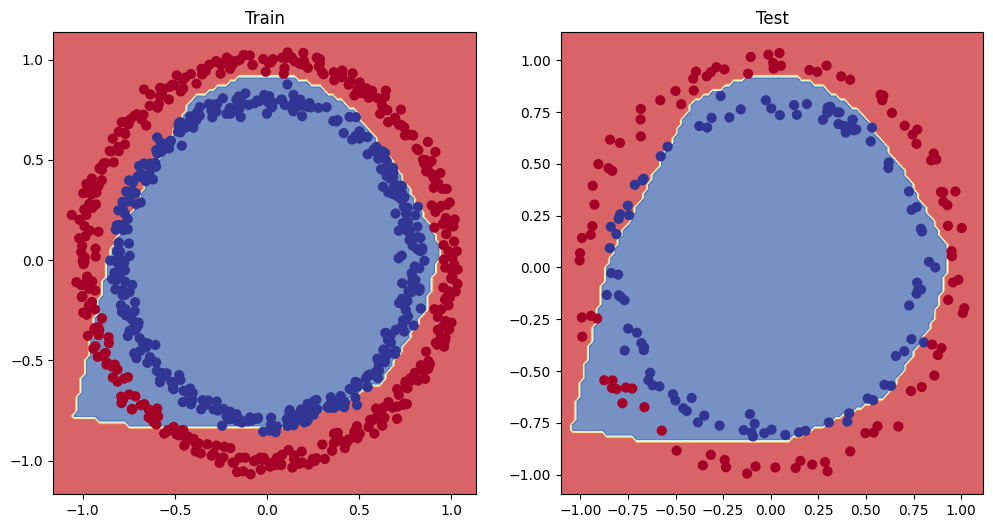

In [ ]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_2, X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

# 5 Putting everything together with multicalss calissification

## 5.1 prepare the data

we will use `sklearn.datasets.make_blobs` toy data set to train our new multicalss classification

In [ ]:
# import the libraries
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

In [ ]:
# set hyperparameters for data creation
NUM_SAMPLES = 1000
NUM_CLASSES = 4
NUM_FEATRUES = 2
RANDOM_SEED = 42

# create the data
X_blobs , y_blobs = make_blobs(n_samples=NUM_SAMPLES, n_features=NUM_FEATRUES, centers=NUM_CLASSES, cluster_std = 1.5, random_state=RANDOM_SEED)

# turn data into tensors
X_blobs = torch.from_numpy(X_blobs).type(torch.float)
y_blobs = torch.from_numpy(y_blobs).type(torch.LongTensor)

# split the data to train and test
X_train , X_test, y_train, y_test = train_test_split(X_blobs, y_blobs, test_size =0.2, random_state=RANDOM_SEED)
# view the data numerically
X_blobs.shape, X_blobs[:5]

(torch.Size([1000, 2]),
 tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]))

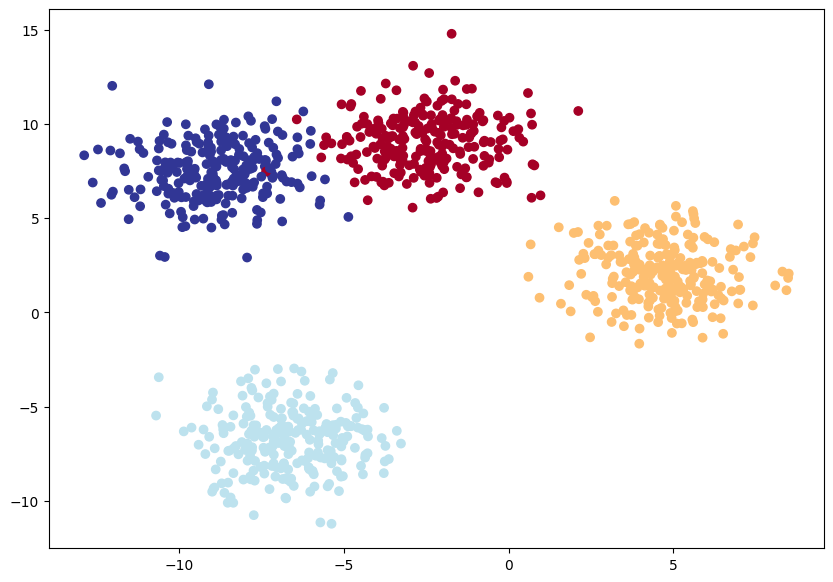

In [ ]:
# plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blobs[:,0], X_blobs[:,1], c=y_blobs, cmap=plt.cm.RdYlBu)

## 5.2 Build the class model

In [ ]:
# create a multi-class classification model
class blobModel(nn.Module):
  def __init__(self, input_features, output_features ,hiddin_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hiddin_units),
        nn.ReLU(),
        nn.Linear(in_features=hiddin_units, out_features=hiddin_units),
        nn.ReLU(),
        nn.Linear(in_features=hiddin_units, out_features = output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_3 = blobModel(input_features=2,output_features=4).to(device)
model_3

blobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 5.3 Setup a loss function and an optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss() # loss function for mulit-class classification

optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

## 5.4 build a training and testing loop

logits (raw output of the model) -> pred prob (use `torch.softamx()`) -> pred labels (use `torhc.argmax` to get the label form the probabilites)

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_test)
y_logits[:5] , y_logits.shape # we have 4 values or features for every label becuas they will point the output feature

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834]]),
 torch.Size([200, 4]))

In [ ]:
y_pred_prob = torch.softmax(y_logits, dim=1)
y_pred_prob[:5] # we converted the logits above to a probabilites for every label

tensor([[0.0835, 0.2883, 0.2298, 0.3984],
        [0.1088, 0.3420, 0.2326, 0.3167],
        [0.1289, 0.3458, 0.2540, 0.2713],
        [0.1194, 0.2778, 0.2748, 0.3280],
        [0.0604, 0.2864, 0.1928, 0.4604]])

In [ ]:
torch.sum(y_pred_prob[0]) # this will equal to 1

tensor(1.)

In [ ]:
# how to get the maximum label ? use torch.argmax()
torch.argmax(y_pred_prob[0])

tensor(3)

In [ ]:
y_preds = torch.argmax(y_pred_prob, dim=1)
y_preds[:5], y_test[:5] # Greate! now we have them in the same format, let's try to build a trainig and testing loops

(tensor([3, 1, 1, 3, 3]), tensor([1., 3., 2., 1., 0.]))

In [ ]:
# build the training and testing loop as a function

def fit(model : torch.nn.Module,
        X_train: torch.Tensor,
        y_train: torch.Tensor,
        X_test: torch.Tensor,
        y_test: torch.Tensor,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim,
        epochs=1000):
  """
    This function will train the model on the givin data and test the accuracy during the training

    Args:
      model (torch.nn.Module): The model to train
      X_train (torch.Tensor): The training data
      y_train (torch.Tensor): The training labels
      X_test (torch.Tensor): The testing data
      y_test (torch.Tensor): The testing labels
      loss_fn (torch.nn.Module): The loss function to use ex: torch.nn.BCEWithLogitsLoss() | torch.nn.CrossEntropyLoss()
      optimizer (torch.optim): The optimizer to use ex : torch.optim.SGD() | torch.optim.Adam()
      epochs (int): The number of epochs to train the model for, default is 1000

  """
  # set the random seeds
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

  # write device agnostic cod and convert the training and testing data to the same device
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  X_train , y_train = X_train.to(device), y_train.to(device)
  X_test , y_test = X_test.to(device), y_test.to(device)

  # the training and testing loop
  for epoch in range(epochs):
    ### Train

    model.train() # set the model in training mode

    y_logits = model(X_train).squeeze(dim=1) # get the raw output from the model (logits)
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1),dim=1) # convert the logits to probabilites (using torhc.softmax) then to labels using (torch.argmax)

    # calculate the loss and the accuracy
    loss = loss_fn(y_logits, y_train) # CrossEntropyLoss takes logits
    acc = accuracy(y_train, y_pred)

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward (backpropagation)
    loss.backward()

    # take a step (gradiant descent)
    optimizer.step()

    ### Testing
    if epoch % 100 == 0:
      model.eval()
      with torch.inference_mode():
        test_logits = model(X_test).squeeze(dim=1)
      test_pred = torch.argmax(torch.softmax(test_logits,dim=1),dim=1)
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy(y_test, test_pred)
      print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%')


In [ ]:
fit(model_3, X_train, y_train, X_test, y_test, loss_fn, optimizer)

Epoch: 0 | Loss: 1.06362 | Acc: 54.62% | Test Loss: 1.00386 | Test Acc: 55.00%
Epoch: 100 | Loss: 0.03295 | Acc: 99.25% | Test Loss: 0.02413 | Test Acc: 99.50%
Epoch: 200 | Loss: 0.02655 | Acc: 99.25% | Test Loss: 0.01648 | Test Acc: 99.50%
Epoch: 300 | Loss: 0.02502 | Acc: 99.25% | Test Loss: 0.01439 | Test Acc: 99.50%
Epoch: 400 | Loss: 0.02427 | Acc: 99.25% | Test Loss: 0.01335 | Test Acc: 99.50%
Epoch: 500 | Loss: 0.02377 | Acc: 99.25% | Test Loss: 0.01268 | Test Acc: 99.50%
Epoch: 600 | Loss: 0.02339 | Acc: 99.25% | Test Loss: 0.01218 | Test Acc: 99.50%
Epoch: 700 | Loss: 0.02307 | Acc: 99.25% | Test Loss: 0.01179 | Test Acc: 99.50%
Epoch: 800 | Loss: 0.02279 | Acc: 99.25% | Test Loss: 0.01147 | Test Acc: 99.50%
Epoch: 900 | Loss: 0.02253 | Acc: 99.25% | Test Loss: 0.01119 | Test Acc: 99.50%


## 5.5 visualize the results

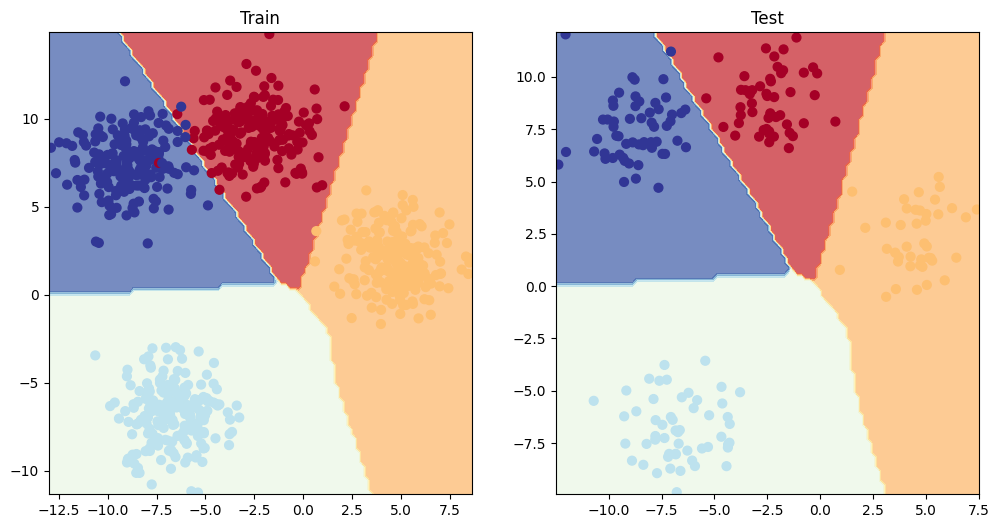

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)